In [1]:
import pandas as pd
import numpy as np
import os
import shutil
from tqdm.notebook import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import random
%matplotlib inline

### Visualizing some images

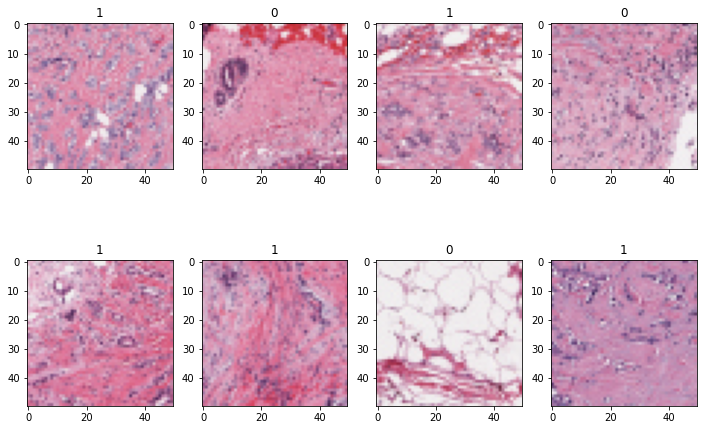

In [2]:
# Show some images
fig = plt.figure(figsize=(12, 8))
patient_id = os.listdir('breast_cancer_image/')
for i in range(8):
    label = str(np.random.choice([0, 1]))
    img_path = 'breast_cancer_image/' + random.choice(patient_id) + '/' + label
    image = Image.open(img_path + '/' + random.choice(os.listdir(img_path)))
    fig.add_subplot(2, 4, i+1)
    plt.imshow(image)
    plt.title(label)

### Organizing the data set
*Separate the grand data into training and testing folder, where each folder contains images categorized into 0 (Non-IDC) and 1 (IDC)*

In [3]:
# Collecting all images from the patients and put them into 0 and 1 folders
base_path = 'breast_cancer_image/'
def transfer(namef, src, dest):
    for filename in namef:
        shutil.copy(src + filename, dest + filename)
try:
    os.makedirs(base_path + 'train/0/')
    os.makedirs(base_path + 'train/1/')
    os.makedirs(base_path + 'test/0/')
    os.makedirs(base_path + 'test/1/')
    
    train_dest0 = base_path + '/train/0/'
    test_dest0 = base_path + '/test/0/'
    train_dest1 = base_path + '/train/1/'
    test_dest1 = base_path + '/test/1/'
    
    for i in tqdm(patient_id):
        # Creat the source path 
        src0 = base_path + i + '/0/'
        src1 = base_path + i + '/1/'
        # Obtain all files in the desired folder
        file0 = os.listdir(src0)
        file1 = os.listdir(src1)

        # Spliting the training and testing folder
        train_file0 = np.random.choice(file0, size=int(len(file0)*0.7), replace=False)
        test_file0 = list(set(file0) - set(train_file0))
        train_file1 = np.random.choice(file1, size=int(len(file1)*0.7), replace=False)
        test_file1 = list(set(file1) - set(train_file1))

        # Using transfer function to move the file to designated foler
        transfer(train_file0, src0, train_dest0)
        transfer(train_file1, src1, train_dest1)
        transfer(test_file0, src0, test_dest0)
        transfer(test_file1, src1, test_dest1)
        
except FileExistsError:
    print('Files are already existed')

Files are already existed


In [4]:
# Check if train and test sets have the same files
train0 = os.listdir(base_path + 'train/0')
test0 = os.listdir(base_path + 'test/0')
set(train0).issubset(set(test0))

False

In [5]:
train1 = os.listdir(base_path + 'train/1')
test1 = os.listdir(base_path + 'test/1')
set(train1).issubset(set(test1))

False

*Check the length of the dataset between two categories*

      Type  Count
0  Non IDC  59527
1      IDC  19076


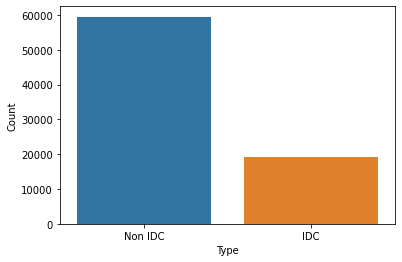

In [6]:
len0 = len(os.listdir(base_path + '/train/0')) 
len1 = len(os.listdir(base_path + '/train/1'))
length = [len0, len1]
countdf = pd.DataFrame({'Type': ['Non IDC', 'IDC'], 'Count': length}, index=range(2))
sns.barplot(x='Type', y='Count', data=countdf)
print(countdf)

*Resampling the 0 category for more balanced data set*

In [7]:
try:
    os.makedirs(base_path + 'new_train/0')
    os.makedirs(base_path + 'new_train/1')
    file0 = np.random.choice(os.listdir(base_path + 'train/0'), size=len1, replace=False)
    for filename in tqdm(file0):
        src = base_path + 'train/0/' + filename
        dest = base_path + 'new_train/0/' + filename
        shutil.copy(src, dest)
    for filename in tqdm(os.listdir(base_path + 'train/1')):
        shutil.copy(base_path + 'train/1/' + filename , base_path + 'new_train/1/' + filename)
except FileExistsError:
    print('Directories are already existed')

# Test Set
try:
    os.makedirs(base_path + 'new_test/0')
    os.makedirs(base_path + 'new_test/1')
    file0 = np.random.choice(os.listdir(base_path + 'test/0'), 
                             size=len(os.listdir(base_path + '/test/1')), replace=False)
    for filename in tqdm(file0):
        src = base_path + 'test/0/' + filename
        dest = base_path + 'new_test/0/' + filename
        shutil.copy(src, dest)
    for filename in tqdm(os.listdir(base_path + 'test/1')):
        shutil.copy(base_path + 'test/1/' + filename , base_path + 'new_test/1/' + filename)
except FileExistsError:
    print('Directories are already existed')

Directories are already existed
Directories are already existed


      Type  Count
0  Non IDC   4821
1      IDC   4821


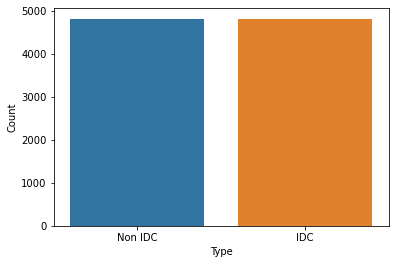

In [8]:
len0 = len(os.listdir(base_path + '/new_test/0')) 
len1 = len(os.listdir(base_path + '/new_test/1'))
length = [len0, len1]
countdf = pd.DataFrame({'Type': ['Non IDC', 'IDC'], 'Count': length}, index=range(2))
sns.barplot(x='Type', y='Count', data=countdf)
print(countdf)

### Data Preprocessing

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(shear_range=0.5, zoom_range=0.2, rescale=1./255)
train_set = train_datagen.flow_from_directory('breast_cancer_image/new_train/', target_size=(50, 50),
                                             batch_size=64, color_mode='rgb', class_mode='binary')
# test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory('breast_cancer_image/new_test/', target_size=(50, 50),
                                           batch_size=64, color_mode='rgb', class_mode='binary')

Found 38152 images belonging to 2 classes.
Found 9642 images belonging to 2 classes.


In [10]:
train_set.class_indices

{'0': 0, '1': 1}

### Building CNN Model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

*First Convolutional Layer*

In [12]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=3, input_shape=(50, 50, 3), activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

*Second Convolutional Layer*

In [13]:
model.add(Conv2D(filters=64, kernel_size=3, input_shape=(50, 50, 3), activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

*Third Convolutional Layer*

In [14]:
model.add(Conv2D(filters=32, kernel_size=3, input_shape=(50, 50, 3), activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

*Flatten the array*

In [15]:
model.add(Flatten())

*Full Connection Model*

In [16]:
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

early_stopping = EarlyStopping(monitor='val_loss', patience=6, mode='min')

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_set, epochs=100, callbacks=[early_stopping], verbose=1,
          validation_data=test_set, workers=10)

Epoch 1/100
597/597 [==============================] - 275s 458ms/step - loss: 0.4877 - accuracy: 0.7740 - val_loss: 0.4130 - val_accuracy: 0.8201
Epoch 2/100
597/597 [==============================] - 268s 448ms/step - loss: 0.4388 - accuracy: 0.8063 - val_loss: 0.4495 - val_accuracy: 0.8055
Epoch 3/100
597/597 [==============================] - 263s 440ms/step - loss: 0.4244 - accuracy: 0.8147 - val_loss: 0.4249 - val_accuracy: 0.8089
Epoch 4/100
597/597 [==============================] - 269s 450ms/step - loss: 0.4150 - accuracy: 0.8192 - val_loss: 0.4411 - val_accuracy: 0.8067
Epoch 5/100
597/597 [==============================] - 266s 445ms/step - loss: 0.4037 - accuracy: 0.8262 - val_loss: 0.3710 - val_accuracy: 0.8441
Epoch 6/100
597/597 [==============================] - 269s 450ms/step - loss: 0.3958 - accuracy: 0.8316 - val_loss: 0.3924 - val_accuracy: 0.8307
Epoch 7/100
597/597 [==============================] - 267s 447ms/step - loss: 0.3860 - accuracy: 0.8343 - val_loss: 0

In [17]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

<Figure size 720x432 with 0 Axes>

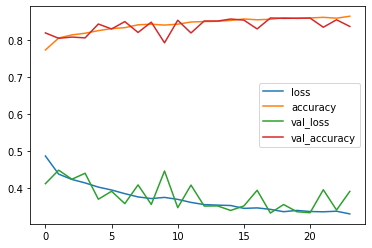

In [18]:
plt.figure(figsize=(10, 6))
losses.plot()

### Model Evaluation

In [19]:
# Convert the format of data from list of array to list
def to_list(x):
    pred = []
    for i in range(len(x)):
        pred.append(int(x[i][0][0]))
    return np.array(pred)

In [20]:
# Make a dataframe for model prediction from test set
file0 = os.listdir(base_path + 'new_test/0')
file1 = os.listdir(base_path + 'new_test/1')
label = list(np.zeros(len(file0))) + list(np.ones(len(file1)))
test_df = pd.DataFrame({'Image': file0 + file1, 'Target': label}).sample(n=len(file0 + file1)).reset_index(drop=True)
test_df

,Image,Target
0,16165_idx5_x3001_y1951_class1.png,1.0
1,9076_idx5_x2551_y1901_class0.png,0.0
2,9382_idx5_x1701_y1051_class1.png,1.0
3,9260_idx5_x2501_y601_class0.png,0.0
4,9075_idx5_x1501_y1101_class0.png,0.0
...,...,...
9637,9255_idx5_x2601_y951_class1.png,1.0
9638,9255_idx5_x3151_y801_class1.png,1.0
9639,9076_idx5_x1751_y2801_class0.png,0.0
9640,8959_idx5_x351_y1251_class0.png,0.0


In [21]:
from keras.preprocessing import image

predictions = []
for item in tqdm(test_df['Image']):
    if item.split('_')[4][5] == '0':
        single_img = image.load_img(base_path + 'new_test/0/' + item, target_size=(50, 50),
                                   color_mode='rgb')
    else:
        single_img = image.load_img(base_path + 'new_test/1/' + item, target_size=(50, 50),
                                   color_mode='rgb')
    single_img = image.img_to_array(single_img)
    single_img = np.expand_dims(single_img, axis=0)
    predictions.append(model.predict(single_img))

  0%|          | 0/9642 [00:00<?, ?it/s]

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(test_df['Target'], to_list(predictions)))
print(confusion_matrix(test_df['Target'], to_list(predictions)))

              precision    recall  f1-score   support

         0.0       0.52      0.99      0.69      4821
         1.0       0.91      0.10      0.18      4821

    accuracy                           0.55      9642
   macro avg       0.72      0.55      0.44      9642
weighted avg       0.72      0.55      0.44      9642

[[4774   47]
 [4326  495]]


In [23]:
preds = []
for file in tqdm(os.listdir(base_path + 'new_data/14078/1')):
    single_img = image.load_img(base_path + 'new_data/14078/1/' + file, target_size=(50, 50))
    single_img = image.img_to_array(single_img)
    single_img = np.expand_dims(single_img, axis=0)
    preds.append(model.predict(single_img))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'breast_cancer_image/new_data/14078/1'

In [ ]:
sum(preds)[0][0]/len(preds)*100